In [32]:
# import library 
import wfdb
import pywt
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras import Model, Input
from tensorflow.python.keras.layers import LSTM, Dropout, Dense,Attention, multiply
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.core import *
from wfdb import processing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm



In [24]:
"""
custom function
"""
# Use the GQRS detection algorithm and correct the peaks
def peaks_hr(sig, peak_inds, fs, title, figsize=(20, 10), saveto=None):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate
    hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
    
    N = sig.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', 
                 color='#8b0000', label='Peak', markersize=12)
    ax_right.plot(np.arange(N), hrs, label='Heart rate', color='m', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')
    ax_right.set_ylabel('Heart rate (bpm)', color='m')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='#3979f0')
    ax_right.tick_params('y', colors='m')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.show()


# compute_hr: This is the compute the heart rate
# sig_len: 
# qrs_ins: 
# fs: frequency
def compute_hr(sig_len, qrs_ins, fs):
    heart_rate = np.full(sig_len, np.nan, dtype = "float32")

    if len(qrs_inds) < 2:
        return heart_rate

    for i in range(0, len(qrs_inds) - 2):
            a = qrs_inds[i]
            b = qrs_inds[i + 1]
            c = qrs_inds[i + 2]
            rr = (b - a) * (1.0 / fs) * 1000
            hr = 60000.0 / rr
            heart_rate[b + 1: c + 1] = hr

            heart_rate[qrs_inds[-1]:] = heart_rate[qrs_inds[-1]]

            return heart_rate
        
# compute_hr_custom: This is the compute the custom hr 
# sig_len: 
# qrs_ins: 
# fs: frequency

def compute_hr_custom(r_peak_1, r_peak_2, fs):
     a = r_peak_1
     b = r_peak_2
     rr = (b - a) * (1.0 / fs)
     hr = 60 / rr

     return hr
    
# dont know wtf for this
def denoise(data):
   
    coeffs = pywt.wavedec(data=data, wavelet='db5', level = 9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata


def plotHeatMap(Y_test, Y_pred):
    con_mat = confusion_matrix(Y_test, Y_pred)
    # 绘图
    plt.figure(figsize=(4, 5))
    seaborn.heatmap(con_mat, annot=True, fmt='.20g', cmap='Blues')
    plt.ylim(0, 5)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()
    
    
    
def buildModel():
    newModel = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(300, 1)),
        # 第一个卷积层, 4 个 21x1 卷积核
        tf.keras.layers.Conv1D(filters=4, kernel_size=21, strides=1, padding='SAME', activation='tanh'),
        # 第一个池化层, 最大池化,4 个 3x1 卷积核, 步长为 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),
        # 第二个卷积层, 16 个 23x1 卷积核
        tf.keras.layers.Conv1D(filters=16, kernel_size=23, strides=1, padding='SAME', activation='relu'),
        # 第二个池化层, 最大池化,4 个 3x1 卷积核, 步长为 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),
        # 第三个卷积层, 32 个 25x1 卷积核
        tf.keras.layers.Conv1D(filters=32, kernel_size=25, strides=1, padding='SAME', activation='tanh'),
        # 第三个池化层, 平均池化,4 个 3x1 卷积核, 步长为 2
        tf.keras.layers.AvgPool1D(pool_size=3, strides=2, padding='SAME'),
        # 第四个卷积层, 64 个 27x1 卷积核
        tf.keras.layers.Conv1D(filters=64, kernel_size=27, strides=1, padding='SAME', activation='relu'),
        # 打平层,方便全连接层处理'
        tf.keras.layers.Flatten(),
        # 全连接层,128 个节点 转换成128个节点
        tf.keras.layers.Dense(128, activation='relu'),
        # Dropout层,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # 全连接层,5 个节点
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return newModel

def plotHeatMap(Y_test, Y_pred):
    con_mat = confusion_matrix(Y_test, Y_pred)
    # 绘图
    plt.figure(figsize=(4, 5))
    seaborn.heatmap(con_mat, annot=True, fmt='.20g', cmap='Blues')
    plt.ylim(0, 5)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()


Loading infants 1 ...


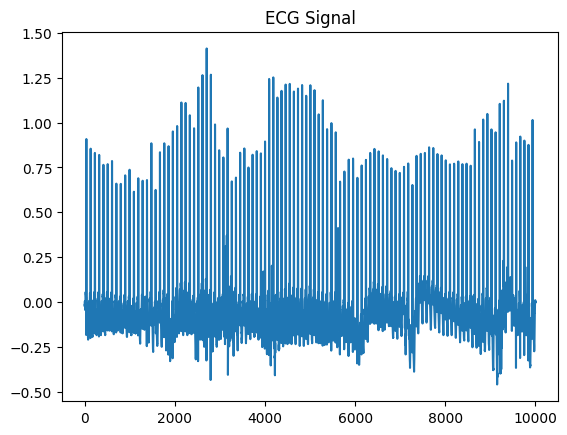

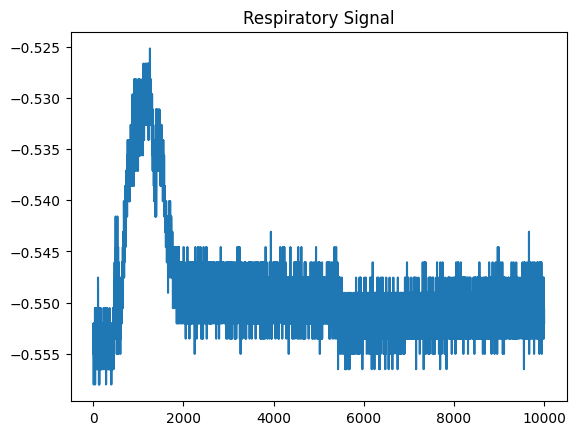

/var/folders/hd/p3q1ts813gq7flnfjj_xpf440000gp/T/ipykernel_48345/575743049.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "rx" (-> marker='x'). The keyword argument will take precedence.
  ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x',
/var/folders/hd/p3q1ts813gq7flnfjj_xpf440000gp/T/ipykernel_48345/575743049.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x',


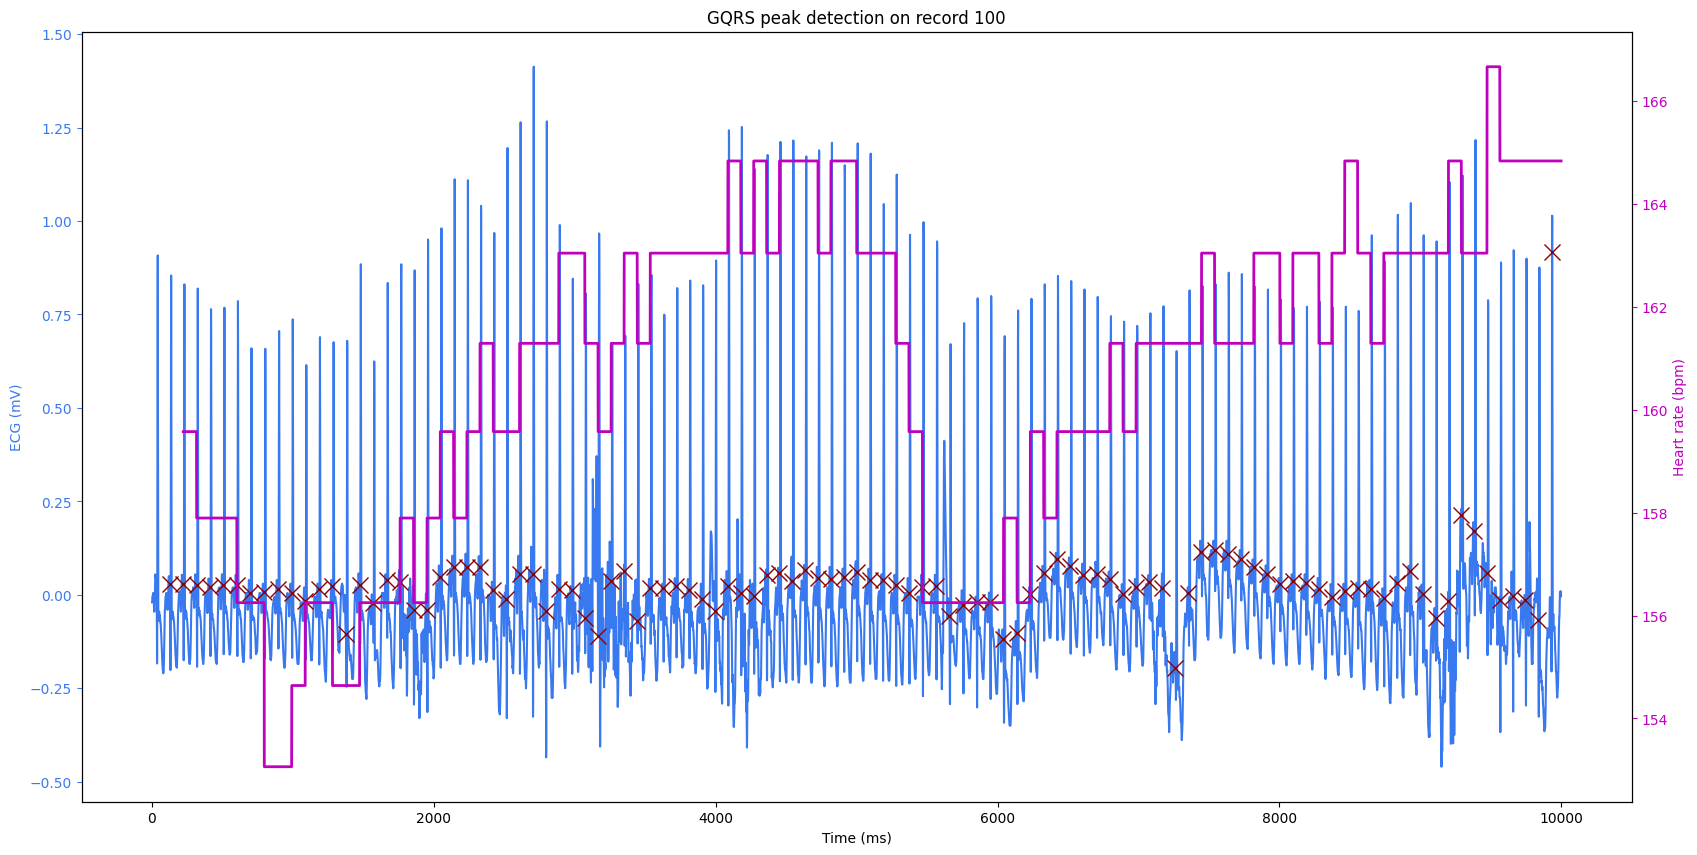

Corrected GQRS detected peak indices: [136, 229, 325, 420, 513, 610, 705, 805, 901, 1000, 1096, 1193, 1289, 1385, 1481, 1577, 1673, 1769, 1865, 1960, 2053, 2149, 2241, 2336, 2429, 2523, 2617, 2709, 2801, 2894, 2986, 3080, 3173, 3265, 3358, 3452, 3545, 3636, 3728, 3820, 3912, 4003, 4094, 4185, 4277, 4369, 4461, 4552, 4642, 4733, 4825, 4917, 5009, 5101, 5193, 5285, 5380, 5477, 5572, 5668, 5763, 5861, 5956, 6050, 6145, 6241, 6336, 6429, 6524, 6617, 6712, 6805, 6898, 6992, 7085, 7177, 7271, 7364, 7456, 7549, 7641, 7733, 7826, 7919, 8012, 8104, 8197, 8289, 8381, 8473, 8564, 8657, 8749, 8841, 8933, 9025, 9117, 9209, 9300, 9392, 9481, 9573, 9665, 9754, 9845, 9937]


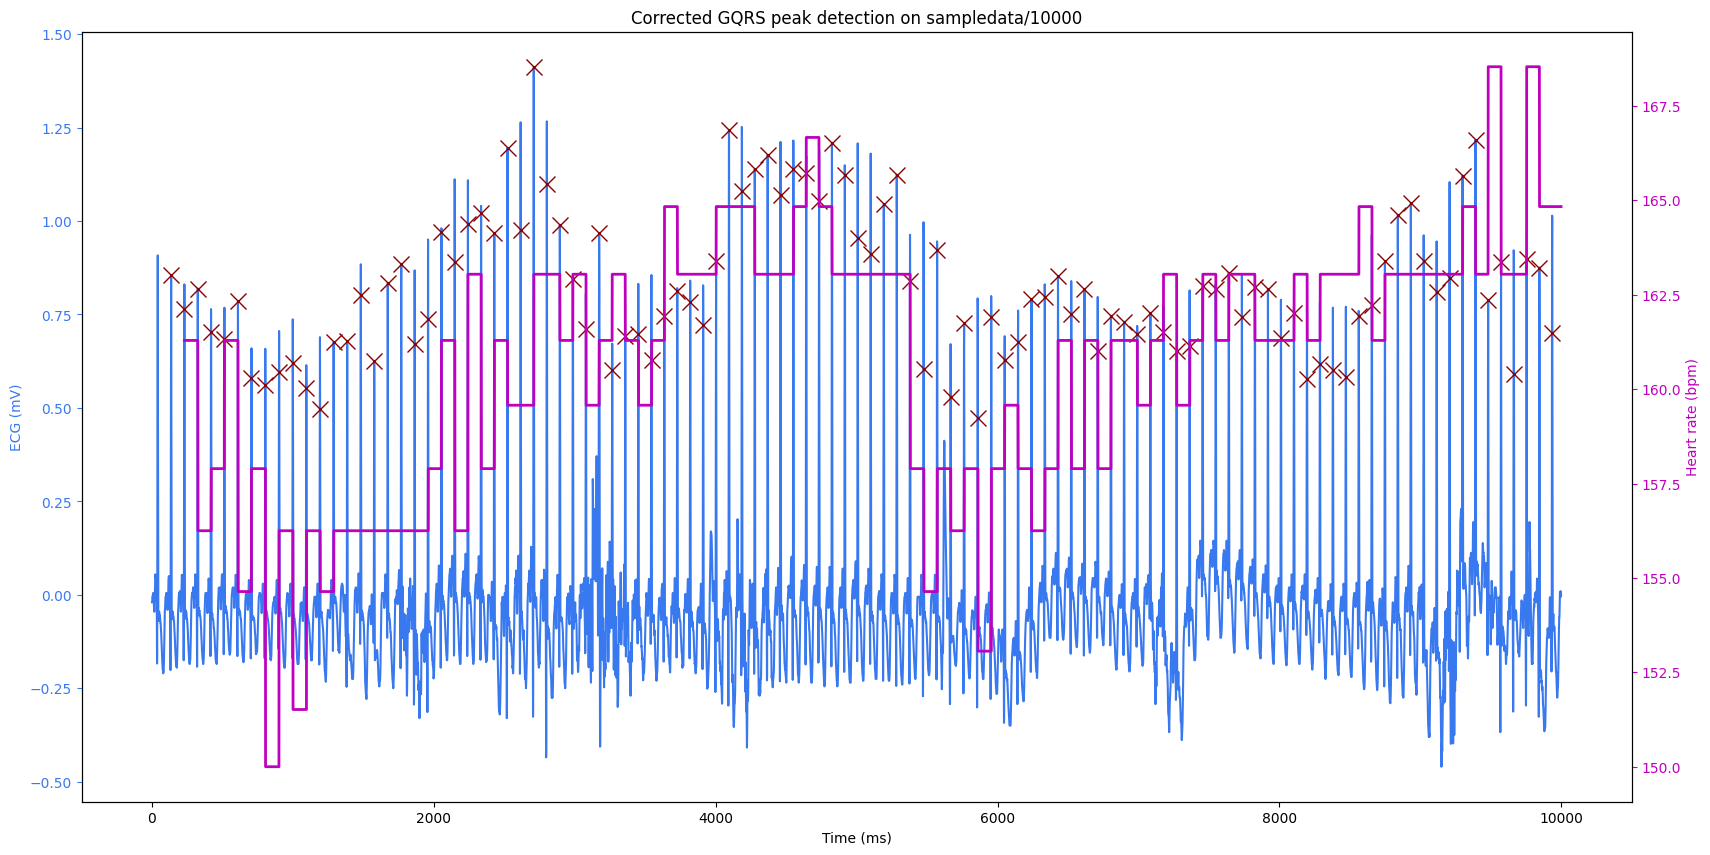

ECG slp frequecy: 250 Hz
ECG slp interval every: 0.004 sec
RESP slp frequecy: 500 Hz
RESP slp interval every: 0.004 sec
heart_df       Infant:  Heart_rate  Time(sec)
0           1         NaN      0.000
1           1         NaN      0.004
2           1         NaN      0.008
3           1         NaN      0.012
4           1         NaN      0.016
...       ...         ...        ...
9995        1  164.835159     39.980
9996        1  164.835159     39.984
9997        1  164.835159     39.988
9998        1  164.835159     39.992
9999        1  164.835159     39.996

[10000 rows x 3 columns]
resp_df       Infant:  Breathing_rate  Time(sec)
0           1             NaN      0.000
1           1             NaN      0.002
2           1             NaN      0.004
3           1             NaN      0.006
4           1             NaN      0.008
...       ...             ...        ...
9995        1             NaN     19.990
9996        1             NaN     19.992
9997        1           

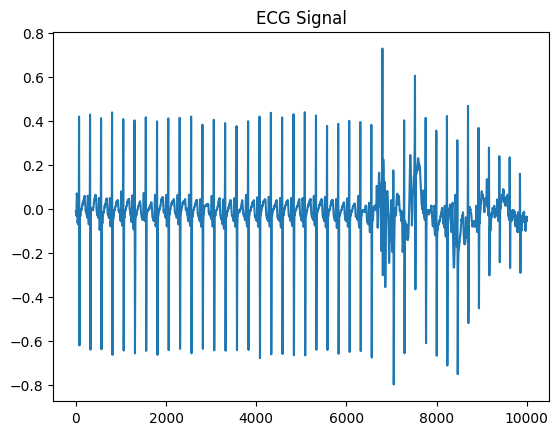

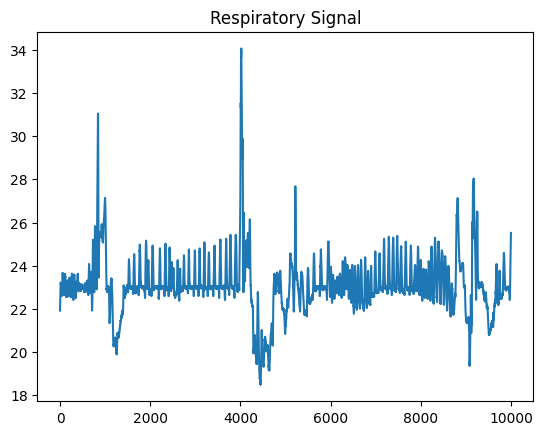

/var/folders/hd/p3q1ts813gq7flnfjj_xpf440000gp/T/ipykernel_48345/575743049.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "rx" (-> marker='x'). The keyword argument will take precedence.
  ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x',
/var/folders/hd/p3q1ts813gq7flnfjj_xpf440000gp/T/ipykernel_48345/575743049.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x',


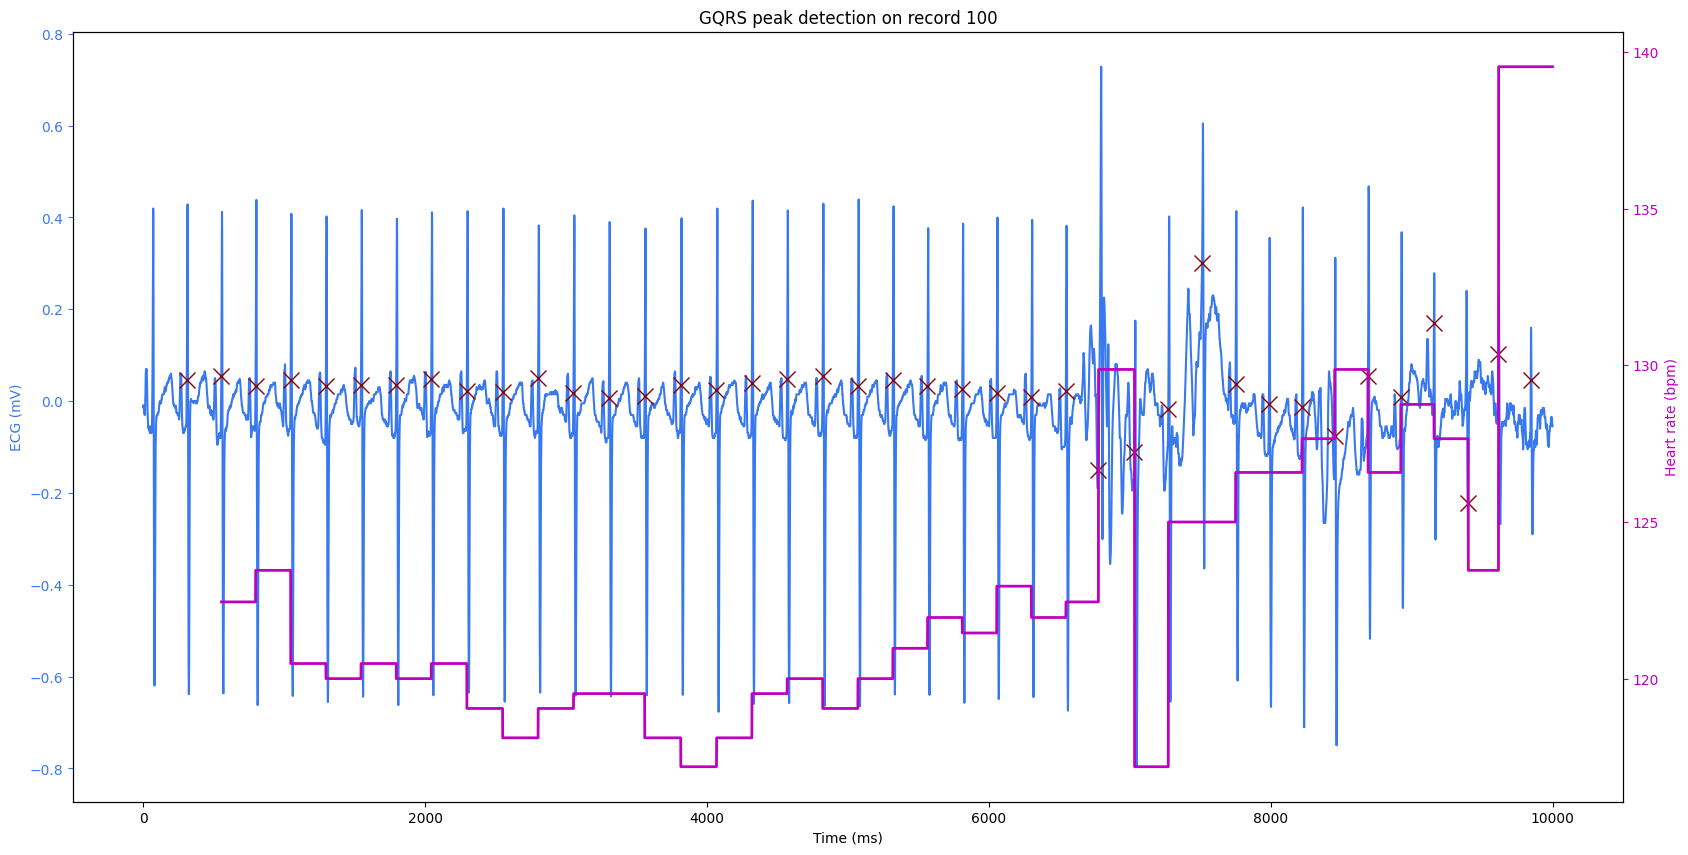

Corrected GQRS detected peak indices: [322, 566, 810, 1059, 1310, 1558, 1809, 2058, 2310, 2563, 2814, 3066, 3318, 3573, 3827, 4082, 4333, 4582, 4834, 5085, 5333, 5578, 5826, 6070, 6317, 6561, 6860, 7049, 7289, 7529, 7765, 8002, 8237, 8466, 8705, 8938, 9170, 9398, 9629, 9857]


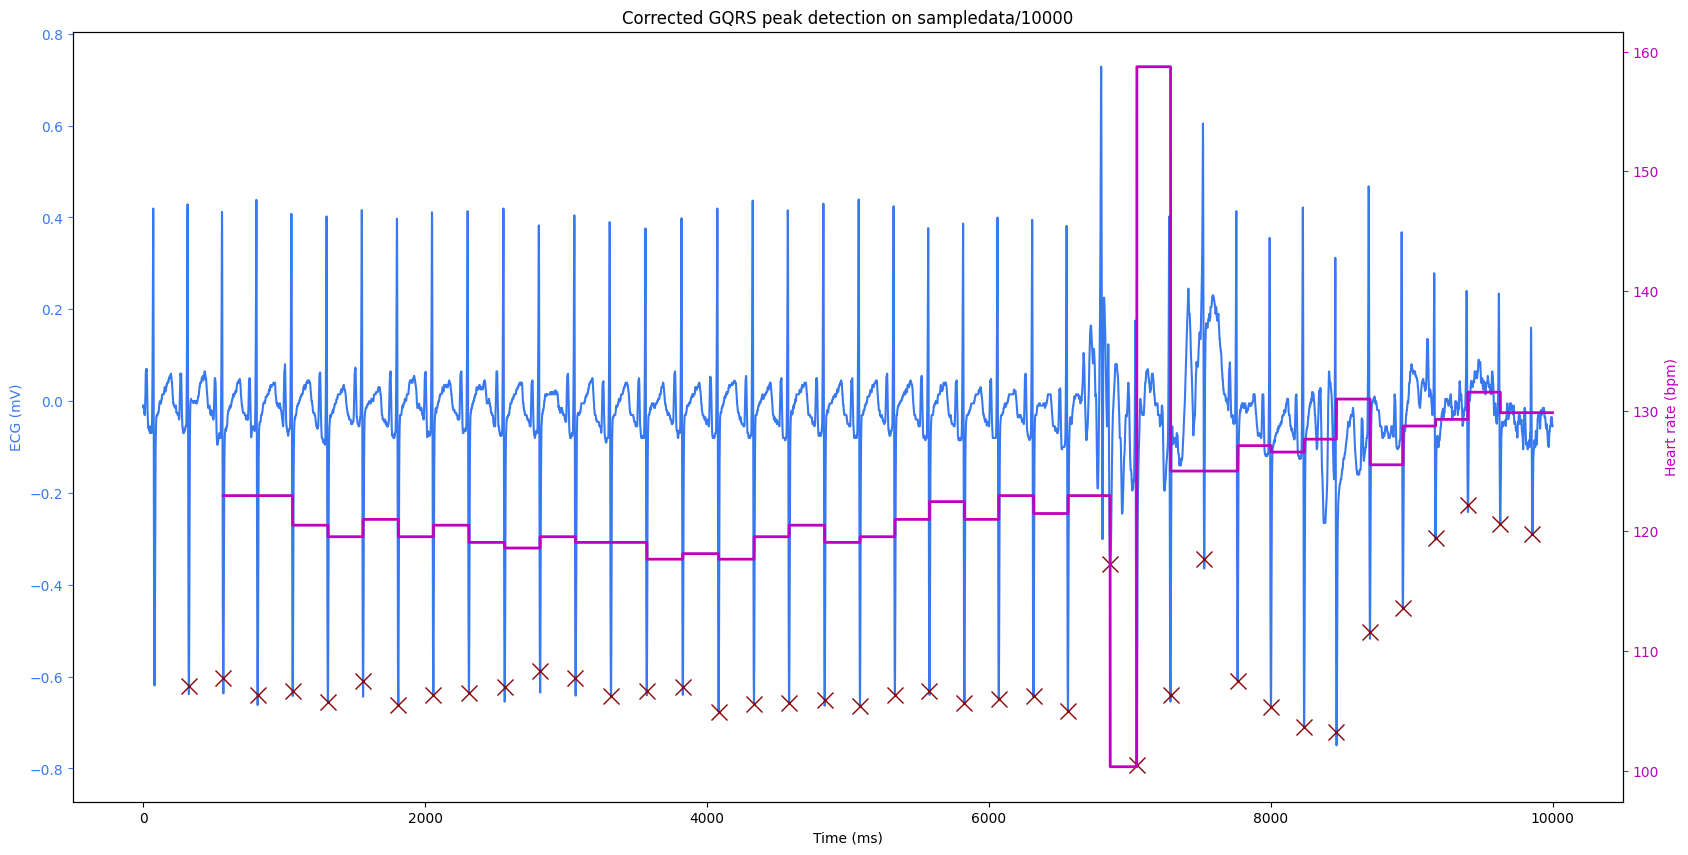

ECG slp frequecy: 500 Hz
ECG slp interval every: 0.002 sec
RESP slp frequecy: 50 Hz
RESP slp interval every: 0.002 sec
heart_df       Infant:  Heart_rate  Time(sec)
0           2         NaN      0.000
1           2         NaN      0.002
2           2         NaN      0.004
3           2         NaN      0.006
4           2         NaN      0.008
...       ...         ...        ...
9995        2  129.870132     19.990
9996        2  129.870132     19.992
9997        2  129.870132     19.994
9998        2  129.870132     19.996
9999        2  129.870132     19.998

[10000 rows x 3 columns]
resp_df       Infant:  Breathing_rate  Time(sec)
0           2             NaN       0.00
1           2             NaN       0.02
2           2             NaN       0.04
3           2             NaN       0.06
4           2             NaN       0.08
...       ...             ...        ...
9995        2       42.857143     199.90
9996        2       42.857143     199.92
9997        2       42.85

In [53]:
  
"""
Step 1: Load sample data for 1..10 infants

heart_data: list of heart rate ECG sample data
resp_data: list of respiratory data

"""
# Constant files
ecg_file = './DataSet/files/picsdb/1.0.0/infant{}_ecg'
resp_file = './DataSet/files/picsdb/1.0.0/infant{}_resp'
numbers_infants = 3
sampfrom = 0
sampto = 10000

for i in range(1, numbers_infants):
    print("Loading infants", i, "...")

    ecg_record = wfdb.rdrecord(ecg_file.format(i), sampfrom = sampfrom, sampto = sampto)
    ecg_annotation = wfdb.rdann(ecg_file.format(i), 'qrsc', sampfrom = sampfrom, sampto = sampto)

    resp_record = wfdb.rdrecord(resp_file.format(i), sampfrom = sampfrom, sampto = sampto)
    resp_annotation = wfdb.rdann(resp_file.format(i), 'resp', sampfrom = sampfrom, sampto = sampto)

#     wfdb.plot_wfdb(record=ecg_record, annotation=ecg_annotation,
#                title='Record from ECG',
#                time_units='minutes')
    
#     wfdb.plot_wfdb(record=resp_record, annotation=resp_annotation,
#                title='Record from respiratory',
#                time_units='minutes')
        

    """DEBUG"""
    # Display record dictionary
    #     display(ecg_record.__dict__)
    #     display(resp_record.__dict__)

    
    # Convert to p_signal
    ecg_p_signal = ecg_record.p_signal
    resp_p_signal = resp_record.p_signal

    # ECG Signal Grpah
    plt.plot(ecg_p_signal)
    plt.title("ECG Signal")
    plt.show()
    
    # Respiratory Signal Grpah
    plt.plot(resp_p_signal)
    plt.title("Respiratory Signal")
    plt.show()

    
#     print(len(ecg_annotation.sample))
#     print(len(resp_annotation.sample))


    """ 
    STEP 1
    REFINING THE GRAPH - ECG
    """
    # Use the GQRS algorithm to detect QRS locations in the first channel
    qrs_inds = processing.qrs.gqrs_detect(sig = ecg_record.p_signal, fs = ecg_record.fs)
    
    # Correct the peaks shifting them to local maxima
    min_bpm = 20
    max_bpm = 230
    min_gap = ecg_record.fs * 60 / min_bpm

    denoise_record_p_signal = denoise(ecg_record.p_signal.flatten())
    denoise_record_fs = ecg_record.fs 
    # denoise_record_fs = denoise(ecg_record.fs) 

    # Use the maximum possible bpm as the search radius
    peaks_hr(sig = ecg_record.p_signal, peak_inds=qrs_inds, fs=ecg_record.fs,
         title="GQRS peak detection on record 100")
    
    search_radius = int(denoise_record_fs * 60 / max_bpm)
    corrected_peak_inds = processing.peaks.correct_peaks(denoise_record_p_signal, 
                                                         peak_inds=qrs_inds,
                                                         search_radius=search_radius, 
                                                         smooth_window_size=150)

    print('Corrected GQRS detected peak indices:', sorted(corrected_peak_inds))
    peaks_hr(sig = ecg_record.p_signal, peak_inds = sorted(corrected_peak_inds), fs=ecg_record.fs,
         title="Corrected GQRS peak detection on sampledata/" + str(sampto))

    """ 
    STEP 1
    REFINING THE GRAPH - Respiratory
    """
#     # Use the GQRS algorithm to detect QRS locations in the first channel
#     qrs_inds_resp = processing.qrs.gqrs_detect(sig = resp_record.p_signal, fs = resp_record.fs)
    
#     # Correct the peaks shifting them to local maxima
#     min_bpm = 20
#     max_bpm = 230
#     min_gap = resp_record.fs * 60 / min_bpm

#     denoise_record_p_signal_resp = denoise(resp_record.p_signal.flatten())
#     denoise_record_fs_resp = resp_record.fs 
#     # denoise_record_fs = denoise(ecg_record.fs) 

#     # Use the maximum possible bpm as the search radius
#     peaks_hr(sig = resp_record.p_signal, peak_inds=qrs_inds_resp, fs=resp_record.fs,
#          title="GQRS peak detection on record 100 - Resp")
    
#     search_radius_resp = int(denoise_record_fs * 60 / max_bpm)
#     corrected_peak_inds_resp = processing.peaks.correct_peaks(denoise_record_p_signal_resp, 
#                                                          peak_inds=qrs_inds_resp,
#                                                          search_radius=search_radius_resp, 
#                                                          smooth_window_size=150)

#     print('Corrected GQRS detected peak indices:', sorted(corrected_peak_inds_resp))
#     peaks_hr(sig = resp_record.p_signal, peak_inds = sorted(corrected_peak_inds_resp), fs=resp_record.fs,
#          title="Corrected GQRS peak detection on sampledata/" + str(sampto))
    
    
    """ 
    STEP 2
    Calculating the heart rate
    Corelation: 
    heart_rate = by checking
    """
    
    # Heart rate and respiratory rate
    heart_rate = processing.compute_hr(len(ecg_record.p_signal), sorted(corrected_peak_inds), ecg_record.fs)
    breathing_rate = processing.compute_hr(len(resp_record.p_signal), resp_annotation.sample, resp_record.fs)

#     custom_hr = compute_hr_custom(ecg_annotation.sample[0], ecg_annotation.sample[1], ecg_record.fs)
#     wfdb_hr = next(x for x in heart_rate if not np.isnan(x))

#     print('Own custom function = ' + str(round(custom_hr, 4)))
#     print('Wfdb function = ' + str(round(wfdb_hr, 4)))
    
    ecg_samp_interval = 1 / ecg_record.fs
    resp_samp_interval = 1 / resp_record.fs

    print("ECG slp frequecy:", ecg_record.fs, "Hz")
    print("ECG slp interval every:", ecg_samp_interval, "sec")

    print("RESP slp frequecy:" , resp_record.fs, "Hz")
    print("RESP slp interval every:", ecg_samp_interval, "sec")
    
    time_ecg = np.arange(ecg_record.p_signal.shape[0]) * ecg_samp_interval
    time_resp = np.arange(resp_record.p_signal.shape[0]) * resp_samp_interval
    
    heart_date = {
        'Infant:': i,
        'Heart_rate': heart_rate,
        'Time(sec)': time_ecg,
    }

    resp_data = {
        'Infant:': i,
        'Breathing_rate': breathing_rate,
        'Time(sec)': time_resp, 
    }

    # dropna() -> Remove NaN
    heart_df = pd.DataFrame.from_dict(heart_date)
    resp_df = pd.DataFrame.from_dict(resp_data)
      
    print("heart_df", heart_df)
    print("resp_df", resp_df)
    
    """
    Train data set
    """
    X_train, X_test, Y_train, Y_test = train_test_split(heart_df, resp_df, test_size=0.2, random_state=42)
    
    
    """
    Data Modelling 1: SVM
    """
    # show unclassified data
#     plt.scatter(X_train, Y_train)
#     plt.show()

#     print("X_train", len(X_train))
#     print("X_test", len(X_test))
#     print("y_train", len(Y_train))
#     print("y_test", len(Y_test))
    
#     clf = svm.SVC(kernel='linear', C=1.0)
#     clf.fit(X_train, Y_train)
    
#     print("")


print("Trained All infants data")


In [ ]:
for i in range(1,numbers_infants):
    record = wfdb.rdrecord(ecg_file)
    ecg_record = wfdb.rdann(ecg_file,'atr')
    annotation = wfdb.rdann(ecg_file,'qrsc')
    sample = ecg_record.sample

    print("========================")
    print("Data Set for infant ", i)
    print("========================")
    print(sample)
    print("\n")

    X = record.p_signal
    y = annotation.sample

    print("Training...")
#     if len(X) < 2 or len(y) < 2:
#         Split the data into train and test sets
#         X_train, X_test, y_train, y_test = train_test_split(X, ecg_annotation, test_size=0.2, random_state=42)

#         # Save the data as .npy files
#         np.save('X_train.npy', X_train)
#         np.save('y_train.npy', y_train)
#         np.save('X_test.npy', X_test)
#         np.save('y_test.npy', y_test)
        
#         plotHeatMap(y_test, y_train)
#         print("Training end...")
#     else:
#         print("No data")

In [ ]:
from tensorflow.keras import Model, Input

 
tf.keras.models.fit(X_train, Y_train, validation_split = "linear")  # validation_split 训练集所占比例
